In [1]:
import cv2
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import json 
import sys 
import tqdm
import torch
from learning.datatools import ApplePointCloudDataset

/home/siddhartha/RIVAL/apple_localize/venv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
config = {
    'voxel_size': 0.03,
    'percentile': 95
}
dataset = ApplePointCloudDataset(data_root="./blender/dataset/raw/apple_orchard-5-20-processed",
                                 manifest_path="./blender/dataset/curated/apple-orchard-v1/train.jsonl",
                                 config=config,
                                 augment=False,
)
# from learning.datatools import pad_collate_fn
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=1,
                                    shuffle=True,
                                    num_workers=12,      
                                    pin_memory=True,
                                    # collate_fn=pad_collate_fn,
                                    )

In [3]:
cloud_sizes = []
occ_rates =[]
bbox_sizes =[]
centers = []
stem_masks = {}

In [11]:
num_clusters = 0
for i, batch in enumerate(dataloader):
    clouds, centers_batch, accessories_batch = batch
    print(centers_batch)
    
    for j in range(clouds.shape[0]):
        cloud = clouds[j]
        cloud_sizes.append(cloud.shape[0])
        print(torch.min(cloud[:,2]), torch.max(cloud[:,2]))
         
    
    break
    
    # Only plot the first item in the first 6 batches
    # if i < 6:
    #     fig = go.Figure()
    #     fig.add_trace(go.Scatter3d(
    #         x=cloud[:, 0].numpy(),
    #         y=cloud[:, 1].numpy(),
    #         z=cloud[:, 2].numpy(),
    #         mode='markers',
    #         marker=dict(
    #             size=2,
    #             color=cloud[:, 3:6] / 255.0
    #         ),
            
    #     ))
    #     fig.add_trace(go.Scatter3d(
    #         x=[center[0][0]],
    #         y=[center[0][1]],
    #         z=[center[0][2]],
    #         mode='markers',
    #         marker=dict(
    #             size=5,
    #             color='red'
    #         ),
    #         name='Center'
    #     ))
    #     fig.update_layout(
    #         scene=dict(
    #             xaxis=dict(nticks=4, range=[-1, 1]),
    #             yaxis=dict(nticks=4, range=[-1, 1]),
    #             zaxis=dict(nticks=4, range=[-1, 1])
    #         ),
    #         width=800,
    #         height=800,
    #         margin=dict(l=0, r=0, b=0, t=0)
    #     )
    #     fig.show()

print("Average cloud size: ", np.mean(cloud_sizes))
print("Average occupancy rate: ", np.mean(occ_rates))
print("Average bbox size: ", np.mean(bbox_sizes))

tensor([[-0.3768,  0.0053, -0.2373]], dtype=torch.float64)
tensor(-1.1463, dtype=torch.float64) tensor(-0.2322, dtype=torch.float64)
Average cloud size:  2781.0
Average occupancy rate:  nan
Average bbox size:  nan


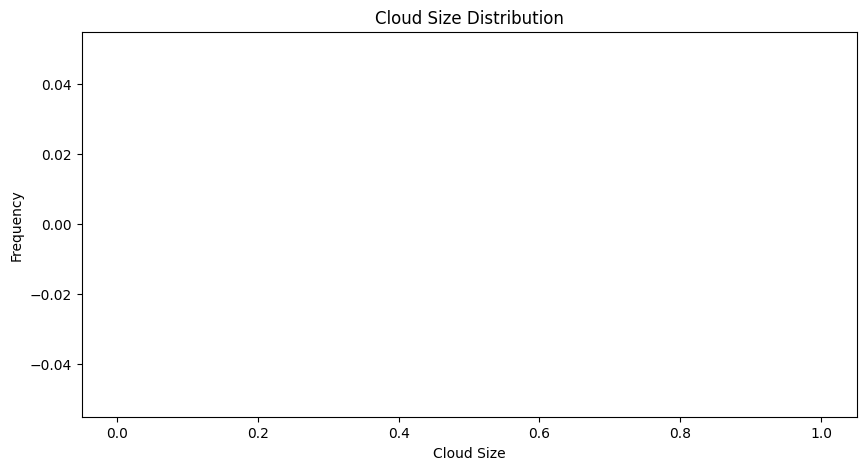

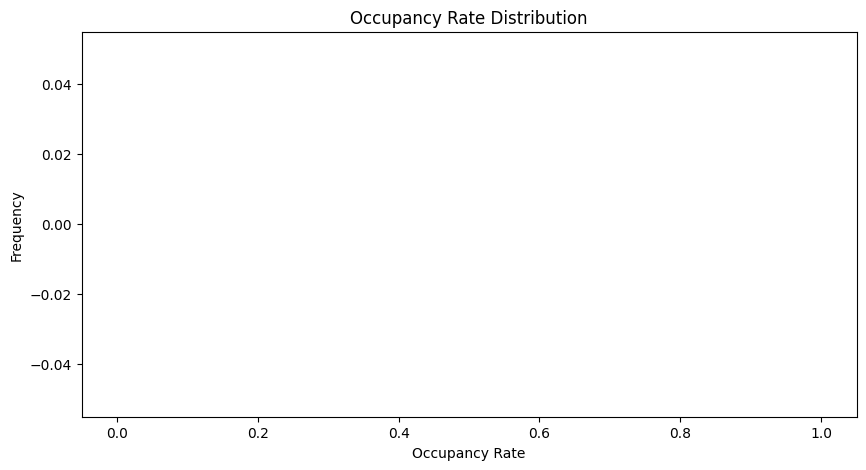

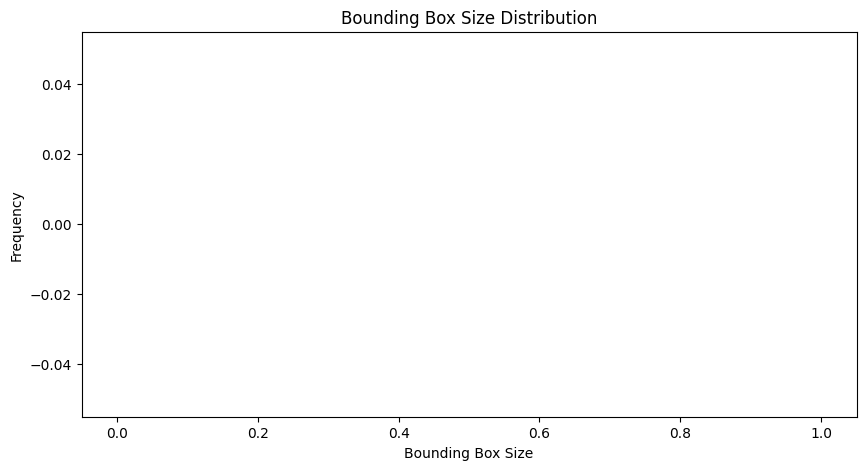

In [5]:
# plot cloud size
plt.figure(figsize=(10, 5))
plt.hist(cloud_sizes, bins=50)
plt.title("Cloud Size Distribution")
plt.xlabel("Cloud Size")
plt.ylabel("Frequency")
plt.show()

# plot occupancy rate
plt.figure(figsize=(10, 5))
plt.hist(occ_rates, bins=50)
plt.title("Occupancy Rate Distribution")
plt.xlabel("Occupancy Rate")
plt.ylabel("Frequency")
plt.show()

# plot bbox size
plt.figure(figsize=(10, 5))
plt.hist(bbox_sizes, bins=50)
plt.title("Bounding Box Size Distribution")
plt.xlabel("Bounding Box Size")
plt.ylabel("Frequency")
plt.show()

In [6]:
man_path = '/home/siddhartha/RIVAL/learning2localize/blender/dataset/curated/apple-orchard-v1/manifest.jsonl'
# load the manifest file
with open(man_path) as f:
    scenes = [json.loads(line) for line in f]


In [7]:
centers = []
for scene in scenes:
    centers.extend(scene['centers'])

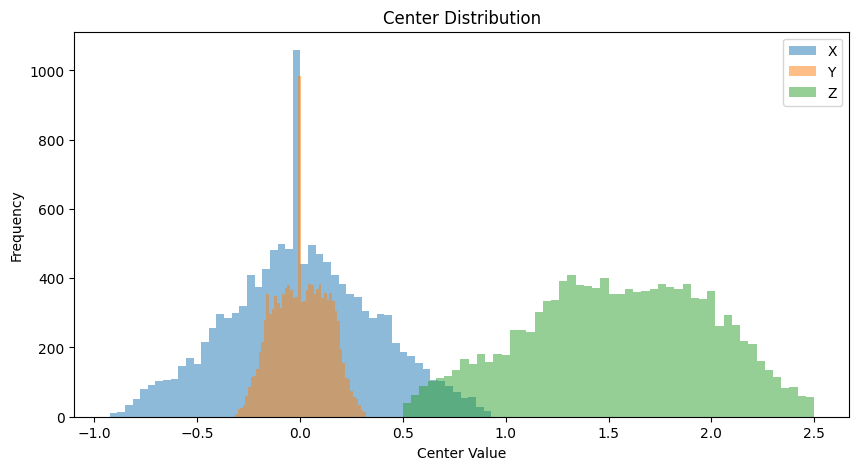

In [8]:
# distribution of centers

x_vals = [c[0] for c in centers]
y_vals = [c[1] for c in centers]
z_vals = [abs(c[2]) for c in centers]
plt.figure(figsize=(10, 5))
#histogram of x, y, z values
plt.hist(x_vals, bins=50, alpha=0.5, label='X')
plt.hist(y_vals, bins=50, alpha=0.5, label='Y')
plt.hist(z_vals, bins=50, alpha=0.5, label='Z')
plt.title("Center Distribution")
plt.xlabel("Center Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# unnormalized centers
# x_vals = []
# y_vals = []
# z_vals = []
# for (center, scale, norm_center) in centers:
#     norm_center = np.array(norm_center).flatten()
#     scale = scale.item()
#     x_vals.append(center[0] + norm_center[0] * scale)
#     y_vals.append(center[1] + norm_center[1] * scale)
#     z_vals.append(center[2] + norm_center[2] * scale)
# plt.figure(figsize=(10, 5))
# #histogram of x, y, z values
# plt.hist(x_vals, bins=50, alpha=0.5, label='X')
# plt.hist(y_vals, bins=50, alpha=0.5, label='Y')
# plt.hist(z_vals, bins=50, alpha=0.5, label='Z')
# plt.title("Unnormalized Center Distribution")
# plt.xlabel("Unnormalized Center Value")
# plt.ylabel("Frequency")
# plt.legend()
# plt.show()


In [9]:
num_clusters = 0
total_apples = 0
stem_boxes = {}
for scene in scenes:
    boxes = scene['boxes']
    mask = np.zeros((1080, 1920), dtype=bool)
    # print(len(boxes))
    
    for box in boxes:
        x1, y1, x2, y2 = box
        if np.any(mask[min(y1,y2):max(y1,y2), min(x1,x2):max(x1,x2)]):
            num_clusters += 1
        else:
            mask[min(y1,y2):max(y1,y2), min(x1,x2):max(x1,x2)] = True
        total_apples += 1
print(f"Number of clusters in manifest: {num_clusters}")
print(f"Total number of apples in manifest: {total_apples}")

Number of clusters in manifest: 2397
Total number of apples in manifest: 12400


In [10]:
train_path = '/home/siddhartha/RIVAL/learning2localize/blender/dataset/curated/apple-orchard-v1/train.jsonl'
test_path = '/home/siddhartha/RIVAL/learning2localize/blender/dataset/curated/apple-orchard-v1/test.jsonl'

# load the manifest file
with open(train_path) as f:
    train_scenes = [json.loads(line) for line in f]
with open(test_path) as f:
    test_scenes = [json.loads(line) for line in f]
train_samples = sum([len(scene['boxes']) for scene in train_scenes])
test_samples = sum([len(scene['boxes']) for scene in test_scenes])
print(f"Total number of samples in train set: {train_samples}")
print(f"Total number of samples in test set: {test_samples}")


Total number of samples in train set: 9920
Total number of samples in test set: 2480
